In [5]:
import torch
import torch.nn as nn
import architectures as arch
from functools import partial
import argparse
from pathlib import Path
from torchvision.ops import MLP
from training import build_trainer
from data_doublependulum import load_double_pendulum_data, setup_dataloaders
from architectures import SingleConvNeuralNet
import matplotlib.pyplot as plt
from training import AcausalPipeline
import numpy as np


parser = argparse.ArgumentParser(description="Double Pendulum training script.")
parser.add_argument("--data", type=Path, default=Path("traj_2s_dt_pow_15_const_params"), help="Path to the directory for the trajectory data.")
parser.add_argument("--epochs", type=int, default=300) # Default epochs changed from 10
parser.add_argument("--batch-size", type=int, default=1) # Default changed from 8
parser.add_argument("--lr", type=float, default=1e-4) # Changed from 1e-3 to 1e-4
parser.add_argument("--weight-decay", type=float, default=1e-8, help="Weight decay (L2 penalty) for Adam optimizer.") # Changed from 1e-4
parser.add_argument("--n-timesteps", type=int, default=11, help="Number of temporal frames to sample from the raw data (consistent with notebook).")

parser.add_argument("--share", action="store_true", help="Share weights between modules.")
parser.add_argument("--no-share", dest="share", action="store_false", help="Don't share weights between modules.")
parser.set_defaults(share=True)

parser.add_argument("--refinement", action="store_true", help="Use refinement.")
parser.add_argument("--no-refinement", dest="refinement", action="store_false", help="Don't use refinement.")
parser.set_defaults(refinement=True)

parser.add_argument("--picard", action="store_true", help="Use Picard iterations.")
parser.add_argument("--no-picard", dest="picard", action="store_false", help="Don't use Picard iterations.")
parser.set_defaults(picard=False)

parser.add_argument("--d_model", type=int, default=64)
parser.add_argument("--nhead", type=int, default=4)
parser.add_argument("--dim_feedforward", type=int, default=64)
parser.add_argument("--dropout", type=float, default=0.0) # changed from 0.1
parser.add_argument("--n_layers", type=int, default=4) # Changed from 4
parser.add_argument("--n_modules", type=int, default=1)
parser.add_argument("--q", type=int, default=1)
parser.add_argument("--r", type=float, default=0.5)

parser.add_argument("--train-kind", choices=["acausal", "causal_one_step", "causal_many_steps"], default="acausal",
                    help="Pipeline kind to use during training")
parser.add_argument("--val-kind", choices=["acausal", "causal_one_step", "causal_many_steps"], default="acausal",
                    help="Pipeline kind to use during validation")

args = parser.parse_args("")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


init_conds, trajs, t_coords = load_double_pendulum_data(args.data, time_trimmed=False)
init_conds = init_conds.to(device)
trajs = trajs.to(device)
t_coords = t_coords.to(device) # Return to this. Will want to send to device every coord in param_coords

train_loader, val_loader = setup_dataloaders(init_conds, trajs, batch_size=args.batch_size)
P = 3 # Parameter encoding
N, T, H, W, Q = trajs.shape


Using device: cuda
Loading double pendulum data...
ICs Loaded
t_coords: tensor([0.0312, 0.0625, 0.0938])
Saved trimmed trajectory to traj_2s_dt_pow_15_const_params/traj_max_time_2_pow_-3_fps_32_dt_pow_15_const_params_trimmed/ic_0_dt_pow_15.npy
Loaded 1 initial conditions
initial_conditions: torch.Size([1, 1, 1, 1, 8])
trajectories: torch.Size([1, 3, 1, 1, 8])
t_coords: torch.Size([3])


In [7]:
encoder = SingleConvNeuralNet(dim=Q,
                                hidden_dim=args.d_model-P,
                                out_dim=args.d_model-P,
                                hidden_ff=128,
                                K=[1,1],
                                S=[1,1])
encoder = encoder.to(device)

# Dummy forward pass to get shapes
with torch.no_grad():
    _, _, H_prime, W_prime, _ = encoder.forward(trajs[0, None, ...].to(device)).shape
block_size = H_prime * W_prime

if args.refinement:
    make_module = partial(arch.AcausalTransformer,
                    d_model=args.d_model,
                    nhead=args.nhead,
                    dim_feedforward=args.dim_feedforward,
                    dropout=args.dropout,
                    n_layers=args.n_layers)
else:
    make_module = partial(arch.BlockCausalTransformer,
                          block_size=block_size,
                          d_model=args.d_model,
                          nhead=args.nhead,
                          dim_feedforward=args.dim_feedforward,
                          dropout=args.dropout,
                          n_layers=args.n_layers)
if args.share:
    modules = arch.make_weight_shared_modules(make_module, n_modules=args.n_modules)
else:
    modules = arch.make_weight_unshared_modules(make_module, n_modules=args.n_modules)
if args.picard:
    model = arch.PicardIterations(modules, q=args.q, r=args.r)
else:
    model = arch.ArbitraryIterations(modules)
model = model.to(device)

decoder = MLP(
    in_channels=H_prime*W_prime*(args.d_model-P),
    hidden_channels=[64, 256, H*W*Q], # Output of the decoder is a H*W*Q length vector
    activation_layer=nn.ELU,
)
decoder = decoder.to(device)

actual_trajectory: torch.Size([1, 3, 1, 1, 8])
ic_0_tensor: torch.Size([1, 1, 1, 8])
actual_trajectory: torch.Size([1, 3, 1, 1, 8])
Storing initial (untrained) model prediction for IC 0...
Stored 1 prediction so far.
preds: tensor([[[[[-0.2664, -0.0123,  0.0832,  0.0133, -0.0822, -0.1340,  0.0470,
            -0.1746]]],


         [[[-0.2585, -0.0138,  0.0833,  0.0082, -0.0908, -0.1333,  0.0452,
            -0.1804]]],


         [[[-0.2493, -0.0170,  0.0837,  0.0039, -0.0996, -0.1322,  0.0432,
            -0.1860]]]]], device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch   1 | train loss: 8.468421 | Train per-dim MSE: [ 7.2988157 39.079628   1.0591592 14.384588   1.0657866  1.1548724
  1.821608   1.8829095]
preds: tensor

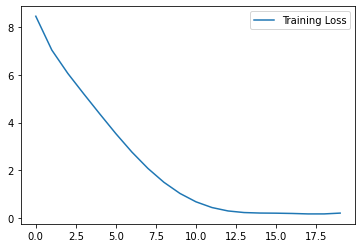

preds: tensor([[[[[2.5242, 6.2490, 0.5628, 3.3322, 0.6077, 0.5782, 0.6296, 0.6005]]],


         [[[2.5236, 6.2478, 0.5624, 3.3308, 0.6071, 0.5778, 0.6293, 0.6001]]],


         [[[2.5230, 6.2465, 0.5620, 3.3294, 0.6065, 0.5773, 0.6291, 0.5997]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch  21 | train loss: 0.243605 | Train per-dim MSE: [0.00715436 0.00964095 0.3752306  0.37659866 0.11180575 0.13227385
 0.5859355  0.35019752]
preds: tensor([[[[[2.4803, 6.2520, 0.6416, 3.2979, 0.6679, 0.5509, 0.6197, 0.6394]]],


         [[[2.4797, 6.2508, 0.6412, 3.2966, 0.6673, 0.5505, 0.6194, 0.6390]]],


         [[[2.4790, 6.2495, 0.6409, 3.2953, 0.6667, 0.5500, 0.6192, 0.6386]]]]],
       device='cuda:0', grad_fn=<

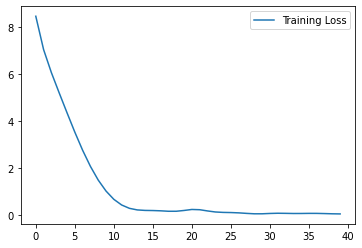

preds: tensor([[[[[2.4129, 6.0153, 0.9254, 3.8306, 0.8857, 0.9195, 1.5188, 1.1039]]],


         [[[2.4127, 6.0148, 0.9251, 3.8300, 0.8855, 0.9193, 1.5188, 1.1038]]],


         [[[2.4124, 6.0142, 0.9249, 3.8294, 0.8852, 0.9192, 1.5187, 1.1037]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch  41 | train loss: 0.053707 | Train per-dim MSE: [0.00166125 0.05845445 0.16304243 0.17974982 0.00313538 0.00048978
 0.01536745 0.00775388]
preds: tensor([[[[[2.4132, 6.0086, 0.9200, 3.7962, 0.8923, 0.8833, 1.4492, 1.0641]]],


         [[[2.4130, 6.0081, 0.9198, 3.7956, 0.8921, 0.8831, 1.4492, 1.0641]]],


         [[[2.4128, 6.0075, 0.9195, 3.7951, 0.8919, 0.8829, 1.4491, 1.0640]]]]],
       device='cuda:0', grad_fn=<

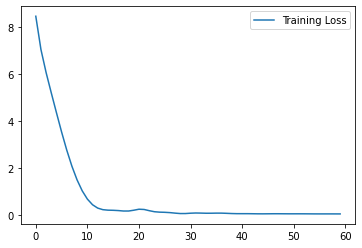

preds: tensor([[[[[2.4225, 6.2110, 1.0238, 3.7584, 0.9370, 0.9496, 1.4823, 1.2036]]],


         [[[2.4223, 6.2104, 1.0235, 3.7578, 0.9368, 0.9494, 1.4822, 1.2035]]],


         [[[2.4221, 6.2097, 1.0232, 3.7571, 0.9366, 0.9492, 1.4821, 1.2034]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch  61 | train loss: 0.043419 | Train per-dim MSE: [1.1588839e-03 1.0086328e-02 1.5082034e-01 1.7742300e-01 2.1855361e-05
 6.3078107e-05 7.6400479e-03 1.3554317e-04]
preds: tensor([[[[[2.4156, 6.1734, 1.0168, 3.7524, 0.9402, 0.9375, 1.4808, 1.1823]]],


         [[[2.4153, 6.1727, 1.0166, 3.7518, 0.9400, 0.9373, 1.4807, 1.1822]]],


         [[[2.4151, 6.1720, 1.0163, 3.7511, 0.9397, 0.9371, 1.4805, 1.1821]]]]],
       de

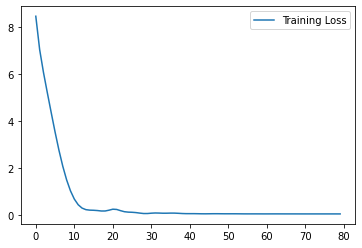

preds: tensor([[[[[2.4388, 6.2570, 1.0339, 3.7535, 0.9426, 0.9357, 1.3844, 1.1972]]],


         [[[2.4385, 6.2562, 1.0336, 3.7528, 0.9424, 0.9355, 1.3843, 1.1970]]],


         [[[2.4382, 6.2553, 1.0333, 3.7520, 0.9421, 0.9353, 1.3842, 1.1969]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch  81 | train loss: 0.042372 | Train per-dim MSE: [7.3977083e-04 9.8372046e-03 1.5064475e-01 1.7758434e-01 8.5035197e-07
 3.5563957e-05 1.1029987e-04 2.6652384e-05]
preds: tensor([[[[[2.4354, 6.2441, 1.0325, 3.7460, 0.9435, 0.9323, 1.3907, 1.1898]]],


         [[[2.4352, 6.2433, 1.0322, 3.7453, 0.9433, 0.9321, 1.3905, 1.1896]]],


         [[[2.4349, 6.2424, 1.0319, 3.7445, 0.9430, 0.9319, 1.3904, 1.1895]]]]],
       de

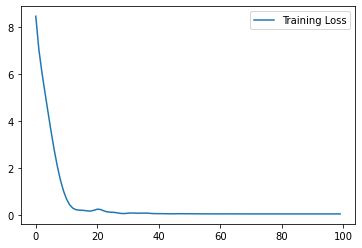

preds: tensor([[[[[2.4402, 6.2373, 1.0355, 3.7817, 0.9436, 0.9379, 1.3845, 1.1950]]],


         [[[2.4398, 6.2363, 1.0352, 3.7808, 0.9434, 0.9377, 1.3843, 1.1949]]],


         [[[2.4395, 6.2353, 1.0348, 3.7800, 0.9431, 0.9374, 1.3841, 1.1947]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 101 | train loss: 0.042228 | Train per-dim MSE: [7.31003587e-04 9.46424901e-03 1.50615901e-01 1.76871404e-01
 3.74187925e-06 1.45776485e-05 1.10565881e-04 8.99175029e-06]
preds: tensor([[[[[2.4391, 6.2352, 1.0353, 3.7768, 0.9432, 0.9363, 1.3847, 1.1924]]],


         [[[2.4387, 6.2342, 1.0349, 3.7760, 0.9429, 0.9361, 1.3845, 1.1922]]],


         [[[2.4384, 6.2332, 1.0346, 3.7751, 0.9427, 0.9359, 1.3843, 1.1920]]]]],
 

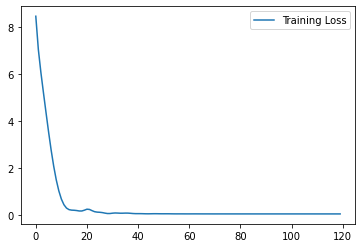

preds: tensor([[[[[2.4423, 6.2348, 1.0368, 3.7824, 0.9427, 0.9406, 1.3940, 1.1939]]],


         [[[2.4419, 6.2337, 1.0364, 3.7815, 0.9424, 0.9404, 1.3938, 1.1936]]],


         [[[2.4415, 6.2325, 1.0361, 3.7805, 0.9421, 0.9402, 1.3935, 1.1934]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 121 | train loss: 0.042201 | Train per-dim MSE: [7.2294491e-04 9.4960285e-03 1.5059087e-01 1.7679308e-01 9.2344794e-07
 1.1230991e-06 1.1324775e-06 3.1910017e-06]
preds: tensor([[[[[2.4416, 6.2338, 1.0366, 3.7817, 0.9423, 0.9401, 1.3932, 1.1931]]],


         [[[2.4412, 6.2327, 1.0363, 3.7807, 0.9420, 0.9398, 1.3930, 1.1929]]],


         [[[2.4408, 6.2315, 1.0359, 3.7797, 0.9418, 0.9396, 1.3927, 1.1927]]]]],
       de

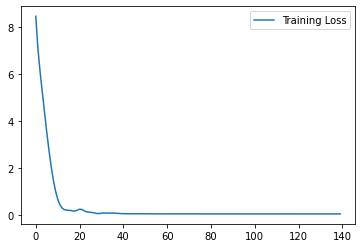

preds: tensor([[[[[2.4441, 6.2380, 1.0371, 3.7785, 0.9420, 0.9415, 1.3958, 1.1927]]],


         [[[2.4437, 6.2367, 1.0367, 3.7774, 0.9417, 0.9412, 1.3956, 1.1924]]],


         [[[2.4432, 6.2354, 1.0363, 3.7763, 0.9414, 0.9410, 1.3953, 1.1921]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 141 | train loss: 0.042189 | Train per-dim MSE: [7.2312111e-04 9.5139630e-03 1.5056801e-01 1.7670517e-01 9.8999251e-08
 8.7646725e-08 6.4809080e-07 3.4189802e-07]
preds: tensor([[[[[2.4437, 6.2374, 1.0371, 3.7785, 0.9418, 0.9413, 1.3956, 1.1926]]],


         [[[2.4433, 6.2361, 1.0366, 3.7774, 0.9416, 0.9411, 1.3953, 1.1923]]],


         [[[2.4428, 6.2348, 1.0362, 3.7763, 0.9413, 0.9408, 1.3951, 1.1920]]]]],
       de

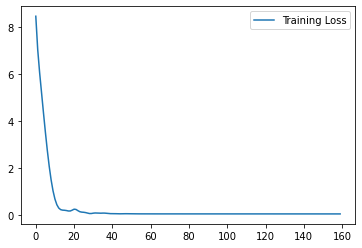

preds: tensor([[[[[2.4443, 6.2380, 1.0369, 3.7792, 0.9418, 0.9417, 1.3953, 1.1922]]],


         [[[2.4438, 6.2366, 1.0365, 3.7780, 0.9415, 0.9415, 1.3950, 1.1919]]],


         [[[2.4433, 6.2351, 1.0360, 3.7768, 0.9412, 0.9412, 1.3947, 1.1916]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 161 | train loss: 0.042180 | Train per-dim MSE: [7.2546344e-04 9.5363446e-03 1.5054683e-01 1.7663383e-01 6.2395245e-08
 4.4847425e-08 1.0192516e-07 6.0963970e-08]
preds: tensor([[[[[2.4442, 6.2380, 1.0369, 3.7791, 0.9418, 0.9417, 1.3953, 1.1922]]],


         [[[2.4437, 6.2365, 1.0365, 3.7779, 0.9415, 0.9414, 1.3950, 1.1919]]],


         [[[2.4432, 6.2351, 1.0360, 3.7767, 0.9412, 0.9411, 1.3948, 1.1916]]]]],
       de

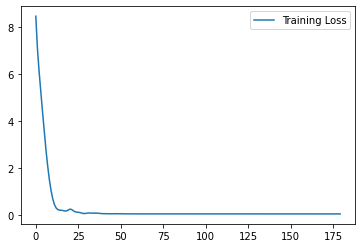

preds: tensor([[[[[2.4440, 6.2376, 1.0368, 3.7795, 0.9418, 0.9418, 1.3950, 1.1921]]],


         [[[2.4434, 6.2361, 1.0364, 3.7782, 0.9415, 0.9415, 1.3947, 1.1918]]],


         [[[2.4429, 6.2345, 1.0359, 3.7769, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 181 | train loss: 0.042173 | Train per-dim MSE: [7.2738942e-04 9.5555680e-03 1.5052851e-01 1.7657135e-01 6.5812408e-08
 5.1110412e-08 7.2812675e-08 7.4887140e-08]
preds: tensor([[[[[2.4440, 6.2376, 1.0368, 3.7795, 0.9418, 0.9418, 1.3951, 1.1921]]],


         [[[2.4435, 6.2361, 1.0364, 3.7783, 0.9415, 0.9415, 1.3947, 1.1918]]],


         [[[2.4429, 6.2345, 1.0359, 3.7770, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       de

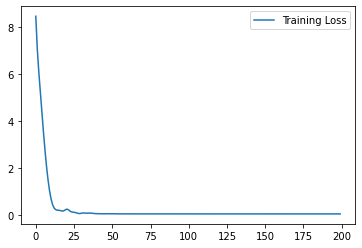

preds: tensor([[[[[2.4440, 6.2379, 1.0369, 3.7794, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2345, 1.0359, 3.7767, 0.9411, 0.9412, 1.3945, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 201 | train loss: 0.042167 | Train per-dim MSE: [7.2904746e-04 9.5716268e-03 1.5051334e-01 1.7652094e-01 7.0579155e-08
 5.4547254e-08 7.7116610e-08 8.2136495e-08]
preds: tensor([[[[[2.4440, 6.2379, 1.0369, 3.7794, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2345, 1.0359, 3.7767, 0.9411, 0.9412, 1.3945, 1.1915]]]]],
       de

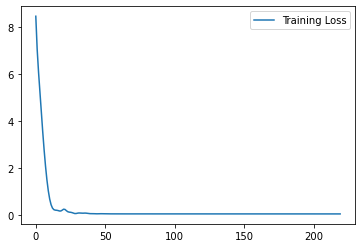

preds: tensor([[[[[2.4440, 6.2379, 1.0369, 3.7795, 0.9418, 0.9417, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2344, 1.0359, 3.7767, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 221 | train loss: 0.042162 | Train per-dim MSE: [7.3028007e-04 9.5833642e-03 1.5050200e-01 1.7648332e-01 7.4348478e-08
 5.7649984e-08 8.3420922e-08 9.0716810e-08]
preds: tensor([[[[[2.4440, 6.2379, 1.0369, 3.7795, 0.9418, 0.9417, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2344, 1.0359, 3.7767, 0.9411, 0.9412, 1.3945, 1.1915]]]]],
       de

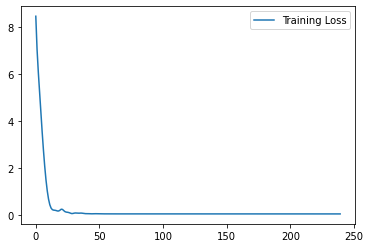

preds: tensor([[[[[2.4441, 6.2379, 1.0369, 3.7795, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2344, 1.0359, 3.7766, 0.9411, 0.9412, 1.3945, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 241 | train loss: 0.042159 | Train per-dim MSE: [7.3112006e-04 9.5910151e-03 1.5049431e-01 1.7645764e-01 7.6926526e-08
 5.9936511e-08 8.9146482e-08 9.6739200e-08]
preds: tensor([[[[[2.4441, 6.2379, 1.0369, 3.7795, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2344, 1.0359, 3.7766, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       de

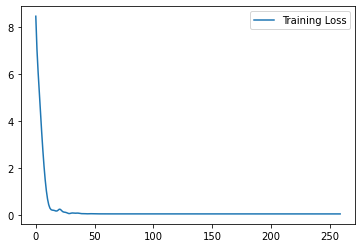

preds: tensor([[[[[2.4441, 6.2380, 1.0369, 3.7796, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2343, 1.0359, 3.7766, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 261 | train loss: 0.042158 | Train per-dim MSE: [7.3160831e-04 9.5956866e-03 1.5049002e-01 1.7644374e-01 7.8251659e-08
 6.1252535e-08 9.2373163e-08 1.0037432e-07]
preds: tensor([[[[[2.4441, 6.2380, 1.0369, 3.7796, 0.9418, 0.9418, 1.3952, 1.1922]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2343, 1.0359, 3.7766, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       de

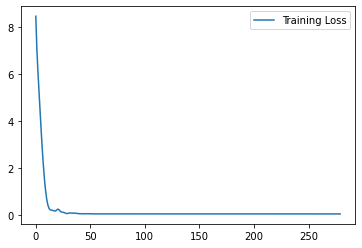

preds: tensor([[[[[2.4441, 6.2380, 1.0369, 3.7796, 0.9418, 0.9418, 1.3952, 1.1923]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2343, 1.0359, 3.7766, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
traj: tensor([[[[[2.4088, 6.1155, 1.5177, 4.2941, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4484, 6.2416, 1.0248, 3.7780, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4732, 6.3516, 0.5666, 3.2622, 0.9415, 0.9415, 1.3948, 1.1919]]]]],
       device='cuda:0')
Epoch 281 | train loss: 0.042157 | Train per-dim MSE: [7.3177129e-04 9.5973071e-03 1.5048838e-01 1.7643771e-01 7.8973081e-08
 6.1803682e-08 9.3354544e-08 1.0161195e-07]
preds: tensor([[[[[2.4441, 6.2380, 1.0369, 3.7796, 0.9418, 0.9418, 1.3952, 1.1923]]],


         [[[2.4434, 6.2362, 1.0364, 3.7781, 0.9415, 0.9415, 1.3948, 1.1919]]],


         [[[2.4428, 6.2343, 1.0359, 3.7766, 0.9411, 0.9412, 1.3944, 1.1915]]]]],
       de

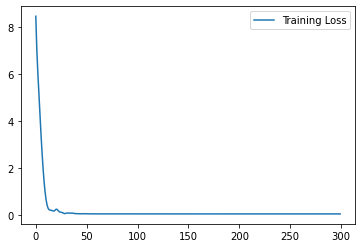

In [8]:
optim = torch.optim.Adam(
    list(model.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=args.lr, weight_decay=args.weight_decay
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=args.epochs)

train_trainer = build_trainer(args.train_kind,
                              encoder=encoder,
                              model=model,
                              decoder=decoder)

val_trainer = build_trainer(args.val_kind,
                            encoder=encoder,
                            model=model,
                            decoder=decoder)

# --- Prediction Storage Setup ---
# Load IC 0 for consistent prediction tracking
try:
    all_ics = np.load("ICs.npy")
    if all_ics.ndim == 1:
        all_ics = np.array([all_ics])
    ic_0 = all_ics[0, 0:4]
    ic_0 = np.append(ic_0, [1, 1, 1, 1]) # Constant pendulum parameters
    # Reshape to (B, H, W, Q) where B=1, H=1, W=1
    init_cond_np = ic_0.reshape(1, 1, 1, 8) 
    ic_0_tensor = torch.from_numpy(init_cond_np).float().to(device)
except FileNotFoundError:
    print("Could not find ICs.npy, skipping prediction storage.")
    ic_0_tensor = None

predictions_over_time = []

if ic_0_tensor is not None:
    # Define the shape of the trajectory we want to predict
    duration = 2**-3  # seconds
    dt = 1/32.0   # seconds
    num_steps = int(duration / dt)

    actual_trajectory = np.load("/home/ubuntu/VirginiaFileSystem/traj_2s_dt_pow_15_const_params/traj_max_time_2_pow_-3_fps_32_dt_pow_15_const_params_trimmed/ic_0_dt_pow_15.npy")
    actual_trajectory = np.append(actual_trajectory[1:, :], np.ones((3, 4)), axis = 1)
    actual_trajectory = torch.from_numpy(actual_trajectory).to(device)
    actual_trajectory = actual_trajectory.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    print(f"actual_trajectory: {actual_trajectory.shape}")

    # Create a dedicated pipeline for generating these predictions using the acausal model
    prediction_pipeline = AcausalPipeline(model, encoder, decoder).to(device)

    def get_prediction(pipeline, ic_tensor, dummy_target):
        """Helper function to get a prediction for a given model state."""
        pipeline.eval()
        with torch.no_grad():
            # The pipeline returns the trajectory starting from frame 1
            pred_tensor = pipeline(ic_tensor, dummy_target)
            # Prepend the initial condition to get the full trajectory
            full_traj = torch.cat([ic_tensor.unsqueeze(1), pred_tensor], dim=1)
        return full_traj.squeeze().cpu().numpy()

    # Store the prediction from the initial, untrained model
    print(f"ic_0_tensor: {ic_0_tensor.shape}")
    print(f"actual_trajectory: {actual_trajectory.shape}")
    print("Storing initial (untrained) model prediction for IC 0...")
    initial_prediction = get_prediction(prediction_pipeline, ic_0_tensor, actual_trajectory)
    predictions_over_time.append(initial_prediction)
    print(f"Stored {len(predictions_over_time)} prediction so far.")


# --- Training Loop ---
training_losses = []
val_losses = []
for epoch in range(1, args.epochs + 1):
    model.train()
    encoder.train()
    decoder.train()
    train_loss, train_per_dim_mse = train_trainer.train_epoch(train_loader, optim)
    training_losses.append(train_loss)
    
    # model.eval()
    # encoder.eval()
    # decoder.eval()
    # val_loss, val_per_dim_mse   = val_trainer.eval_epoch(val_loader)
    # val_losses.append(val_loss)

    scheduler.step()
    
    # Using .cpu().numpy() in the print statement for cleaner output
    # print(f"Epoch {epoch:3d} | train loss: {train_loss:.6f} | val loss: {val_loss:.6f} | Train per-dim MSE: {train_per_dim_mse.cpu().numpy()} | Val per-dim MSE: {val_per_dim_mse.cpu().numpy()}")
    print(f"Epoch {epoch:3d} | train loss: {train_loss:.6f} | Train per-dim MSE: {train_per_dim_mse.cpu().numpy()}")
    
    if epoch % 20 == 0:
        if ic_0_tensor is not None:
            # Store prediction for the current model state
            print(f"Storing prediction for IC 0 at epoch {epoch}...")
            current_prediction = get_prediction(prediction_pipeline, ic_0_tensor, actual_trajectory)
            predictions_over_time.append(current_prediction)
            print(f"Stored {len(predictions_over_time)} predictions so far.")

        # Plotting losses
        plt.plot(training_losses, label="Training Loss")
        # plt.plot(val_losses, label="Validation Loss")
        plt.legend()
        plt.show()

np.save("one_datum_predictions.npy", predictions_over_time)

# torch.save({"state_dict": model.state_dict()}, Path("tmpweights.pt"))

